In [47]:
import sys
import numpy as np
import pandas as pd
from fingerprints.get_fp import output, input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
%matplotlib inline

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier


In [63]:
labels_kmeans = pd.read_csv('data/labels_kmeans.csv').set_index('CID')
labels_manual = pd.read_csv('data/labels_manual.csv').set_index('CID')
labels_hrc = pd.read_csv('data/labels_hrc.csv').set_index('CID')

kmeans_counts = labels_kmeans.sum().sort_values(ascending=False)
manual_counts = labels_manual.sum().sort_values(ascending=False)
hierarchical_counts = labels_hrc.sum().sort_values(ascending=False)

print(kmeans_counts, hierarchical_counts, manual_counts)

fingerprint = input

cluster_5    1772
cluster_4    1377
cluster_0    1220
cluster_7    1168
cluster_1    1111
cluster_8    1018
cluster_3     896
cluster_2     821
cluster_6     551
dtype: int64 cluster_3    2840
cluster_7    1377
cluster_0    1161
cluster_5     896
cluster_8     821
cluster_1     767
cluster_4     551
cluster_6     403
cluster_2     399
dtype: int64 fruity        1736
general       1287
spices        1189
sweet         1170
savoury       1136
green         1101
earthy        1050
sharp          635
artificial     247
dtype: int64


In [49]:
from sklearn.model_selection import StratifiedKFold

def kfold_cv(X, y, k, H, cv_fun, random_state):
    """
    Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
    of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

    :param X: feature matrix.
    :param y: response column.
    :param k: number of folds.
    :param H: values of the hyperparameter to cross-validate.
    :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
        as a function of h. It must return a dictionary with metric score values.
    :param random_state: controls the pseudo random number generation for splitting the data.
    :return: a Pandas dataframe with metric scores along values in H.
    """
    kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
    scores = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        
        # for each fold 1..K
        kk = 0
        for train_index, valid_index in kf.split(X, y):
            kk = kk+1
            # partition the data in training and validation
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # call cv_fun to train the model and compute performance
            fold_scores = {'_h': h, '_fold': kk}
            fold_scores.update(cv_fun(X_train, y_train, X_valid, y_valid, h))
            scores.append(fold_scores)
            
    return pd.DataFrame(scores)

## kmeans

In [64]:
y = labels_kmeans
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)


In [65]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.16045845272206305 

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       245
           1       0.74      0.50      0.60       228
           2       0.45      0.18      0.26       148
           3       0.67      0.34      0.45       177
           4       0.79      0.56      0.66       292
           5       0.65      0.64      0.64       343
           6       0.55      0.25      0.34       106
           7       0.68      0.49      0.57       231
           8       0.68      0.39      0.50       214

   micro avg       0.69      0.49      0.57      1984
   macro avg       0.66      0.45      0.53      1984
weighted avg       0.68      0.49      0.56      1984
 samples avg       0.66      0.53      0.55      1984



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


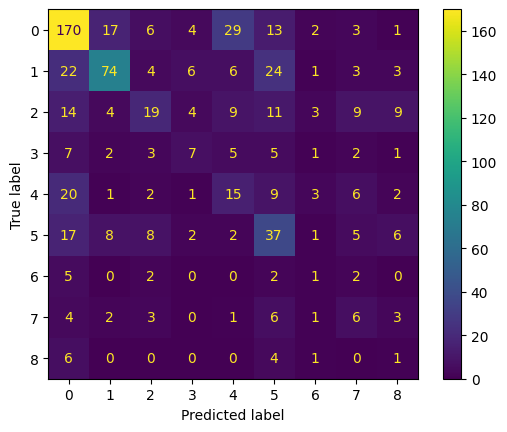

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

## manual

In [67]:
y = labels_manual
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [68]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3).fit(X_train, y_train)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

print(y_pred)


Accuracy: 0.08739255014326648 

              precision    recall  f1-score   support

           0       0.83      0.65      0.73       363
           1       0.56      0.32      0.41       206
           2       0.65      0.37      0.47       219
           3       0.64      0.38      0.48       202
           4       0.68      0.56      0.61       218
           5       0.69      0.48      0.56       249
           6       0.64      0.16      0.26        55
           7       0.52      0.24      0.33       126
           8       0.61      0.38      0.47       275

   micro avg       0.68      0.44      0.54      1913
   macro avg       0.65      0.39      0.48      1913
weighted avg       0.67      0.44      0.53      1913
 samples avg       0.63      0.46      0.49      1913

[[1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


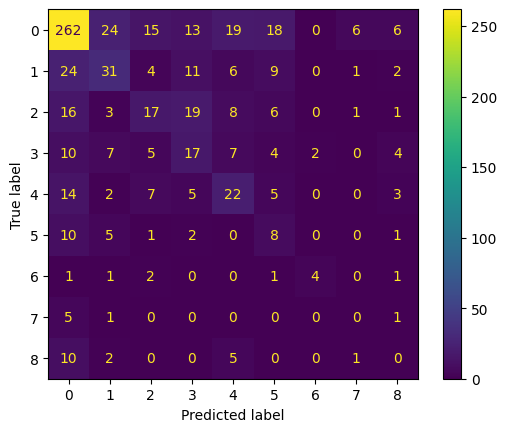

In [69]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

## hrc

In [70]:
y = labels_hrc
X = fingerprint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)


In [71]:
m_rf = RandomForestClassifier(n_estimators = 10, max_features = 3).fit(X_train, y_train)
multi_target_rf = MultiOutputClassifier(m_rf).fit(X_train, y_train)
y_pred = multi_target_rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred), "\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.2148997134670487 

              precision    recall  f1-score   support

           0       0.70      0.51      0.59       244
           1       0.75      0.45      0.56       150
           2       0.50      0.14      0.22        76
           3       0.82      0.94      0.87       562
           4       0.53      0.22      0.31       106
           5       0.74      0.38      0.50       177
           6       0.51      0.42      0.46        76
           7       0.81      0.60      0.69       292
           8       0.44      0.24      0.31       148

   micro avg       0.74      0.58      0.65      1831
   macro avg       0.65      0.43      0.50      1831
weighted avg       0.72      0.58      0.62      1831
 samples avg       0.79      0.64      0.66      1831



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


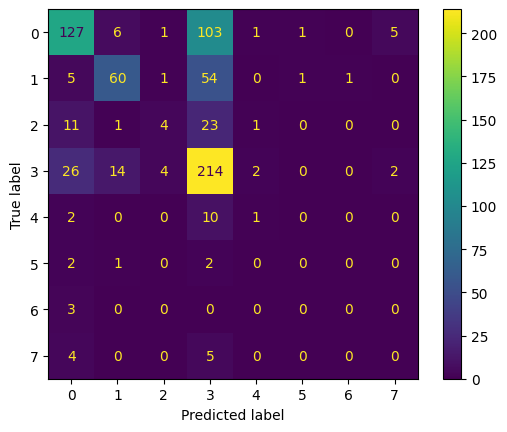

In [72]:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))